# Averaging ERPs: Creating MNE Evoked objects

Since averaging across trials is typically the end goal of an ERP experiment, MNE has a distinct class, `Evoked`, for ERP data where multiple trials have been averaged for each experimental condition or trial type. 

We'll firstimport MNE and the mastoid-referenced, cleaned epochs we saved in the previous step. 

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

# Participant ID code
p_id = 'sub-001'
data_dir = 'data/' + p_id + '/'

epochs = mne.read_epochs(data_dir + p_id + '-epo.fif', preload=True)

## Create Evoked objects

Unlike `Epochs`, which by definition contain multiple trials and in which each trial has an associated condition label (event code), `Evoked` data sets are averages across trials for a *single* condition. Thus we have to create a separate `Evoked` object for each condition in our experiment. For convenience, we can store these in a list, and we can created the list of Evoked objects using dictionary comprehension, so that each dictionary key is the condition name and its value is the Evoked object:

In [2]:
conditions = ['Match', 'Mismatch']

evokeds = {c:epochs[c].average() for c in conditions}

evokeds    

{'Match': <Evoked | '0.26 × Match/A + 0.25 × Match/C + 0.26 × Match/B + 0.23 × Match/D' (average, N=69), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>,
 'Mismatch': <Evoked | '0.26 × Mismatch/A + 0.22 × Mismatch/C + 0.25 × Mismatch/B + 0.26 × Mismatch/D' (average, N=68), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>}

## Plot average ERP for each condition

We can use a method called `plot_joint()` to generate a combination of "butterfly" plots (waveforms of all electrodes overlaid) and topographic maps at specific time points that we specify. This is a nice way of relating scalp topographies and waveforms. The time points specified for the topo plots were selected based on early peaks apparent in the waveforms above, and then on 200 ms intervals over the time period when the N400 is expected:

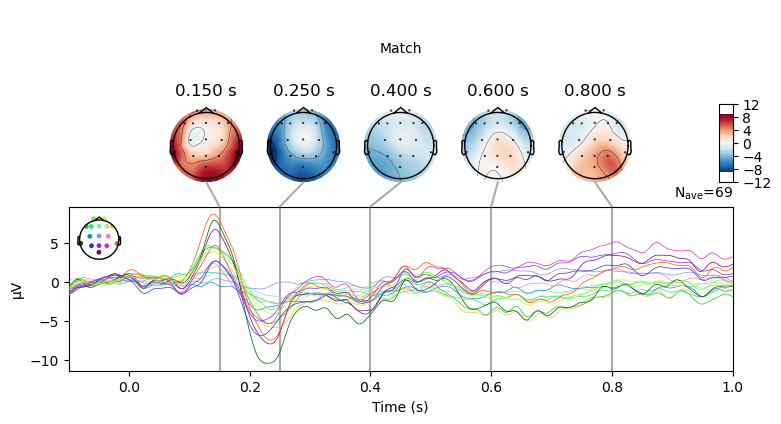

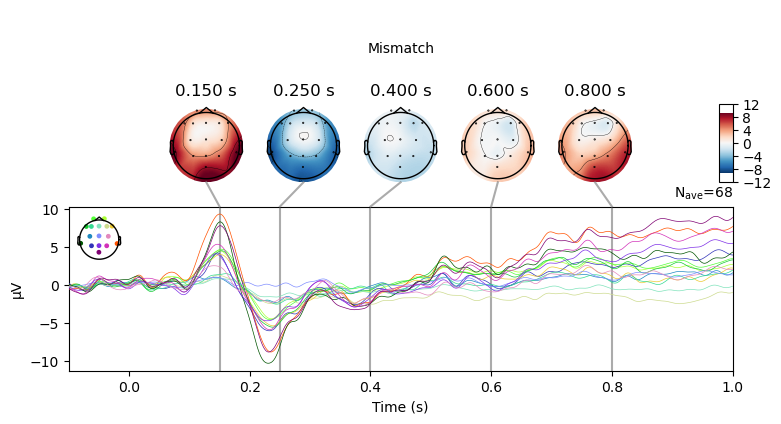

In [3]:
times = [.150, .250, .400, .600, .800]
for c in evokeds.keys():
    evokeds[c].plot_joint(times=times, title=c);

## Examine contrasts between conditions

Viewing the ERPs for each experimental condition is a good first step, but ultimately any ERP experiment should be designed around *contrasts* between different conditions. In the present study, we are interested in the difference between match and mismatch items. We predicted an N400 component, which would be larger (more negative) for mismatch than match items. The N400 tends to be largest over the midline centre/posterior region of the scalp (when using averaged-mastoid reference). So here we will plot the data at electrode Cz, which typically shows the N400 effect. We use the function `mne.viz.plot_compare_evokeds()`, which plots waveforms for each of a list of evoked items that you pass to it:

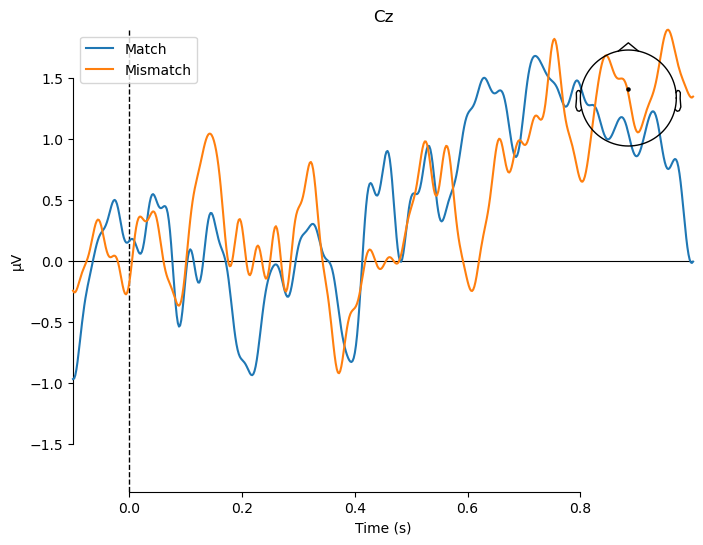

In [4]:
mne.viz.plot_compare_evokeds(evokeds, 
                             picks='Cz');

We can make this plot a bit nicer by adding a few things to it:
- firstly we define a *region of interest* (ROI) that includes a set of electrodes where the N400 is expected, so that we can plot the ERP waveform averaged over these electrodes
- we add the `combine` kwarg to tell MNE how to combine the data from these electrodes
- we define dictionaries mapping condition names to colours and linestyles for out plot, to make the two conditions' lines more distinctive
- we tell MNE where to put the legend and plot of the sensor locations, to ensure these don't overlap with the waveforms

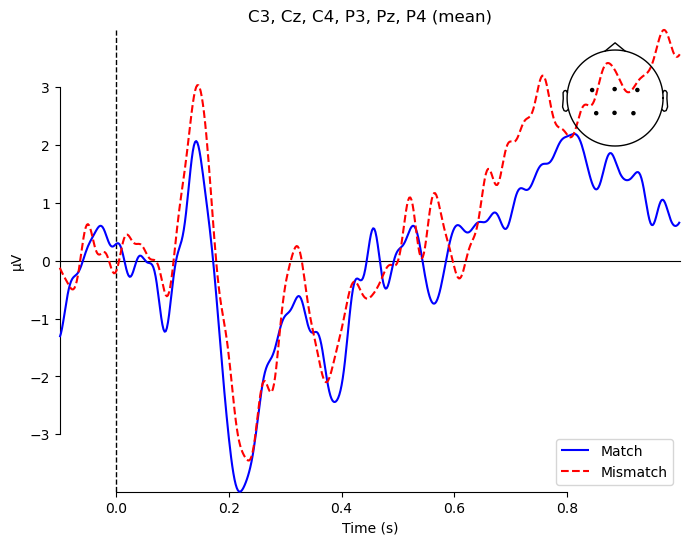

In [5]:
roi = ['C3', 'Cz', 'C4', 
       'P3', 'Pz', 'P4']

color_dict = {'Match':'blue', 'Mismatch':'red'}
linestyle_dict = {'Match':'-', 'Mismatch':'--'}

mne.viz.plot_compare_evokeds(evokeds, combine='mean', 
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict);

The N400 can be observed as the difference between the two conditions' waveforms starting just after 400 ms. As predicted, the Mismatch waveform is more negative than the Match waveform. In most cases, the N400 lasts for about 200 ms. However, in this particular individual's data, under these task conditions, the larger negativity for Mismatch lasts until the end of the epoch.

## Save Evokeds to File

We can save Evoked objects to files using `mne.write_evokeds()`. Note that this function does not accept a dictionary as input, only a single `Evoked` object, or a list of `Evoked` objects, so below we convert the values of `evokeds` to a list using the `list()` function.

### Add Labels to Evoked Objects
One potential source of error here is that, unlike dictionaries, lists don't have labels for their entries. So in a list of `Evoked` objects, we risk not knowing later which list item corresponds to which condition. Fortunately, MNE provides a way to label Evoked objects: the `.comment` property:

In [6]:
evokeds['Match'].comment

'0.26 × Match/A + 0.25 × Match/C + 0.26 × Match/B + 0.23 × Match/D'

At the moment, this does indicate what condition the data are from, but in a somewhat messy way. Indeed, the comment there reflects the result of averaging the 4 different *Match* conditions into one `Evoked` object; the 02.5 values reflect the weighting of each condition in the average, which was based on the number of trials in each. In this case, we had equal numbers of trials of each of the four *Match* conditions, so all the weights are 25%. Since this information isn't terribly relevant now that we are treating all four conditions as the same (simply *Match*), so we can change the contents of the `.comment` property through assignment:

In [7]:
for condition in evokeds.keys():
    evokeds[condition].comment = condition

evokeds

{'Match': <Evoked | 'Match' (average, N=69), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>,
 'Mismatch': <Evoked | 'Mismatch' (average, N=68), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>}

Now that we have comments that will help clearly identify each `Evoked` object later, we can write these out to a file. 

### Write Evoked Objects to File
MNE imposes file naming conventions (rules), which specify that Evoked file names should always end in `-ave.fif`. It's good practice to use the participant ID and condition name in the file name as well. The `write_evoked()` function requires the output file name as its first argument, and the Evoked data as the second argument. 

In [8]:
mne.write_evokeds(data_dir + p_id + '-ave.fif', 
                  list(evokeds.values()),
                  overwrite=True
                 )

## Create difference waves 

Finally, we can create **difference waves** by subtracting the waveforms of our two experimental conditions. Since the N400 manifests as a larger negativity for mismatch, it is conventional to compute this difference as Mismatch - Match (otherwise the difference between the two would appear as positive, rather than negative, voltage). 

Computing difference waves allows us to view the experimental effect in a quite intuitive way: zero voltage means no difference between conditions, and and deviation from the zero line in the waveform plot (or from white in the topopmaps) indicates an experimental effect.

MNE's `combine_evoked()` function allows us to combine Evoked data sets in different ways. To compute a difference, we pass the weights of `[1, -1]` to indicate we want to subtract the second Evoked data set listed (Match) from the first (Mismatch):

In [9]:
evokeds_diff = mne.combine_evoked([evokeds['Mismatch'], 
                                   evokeds['Match']
                                   ], 
                                  weights=[1, -1]
                                  )
    
evokeds_diff    # check the difference waveform

<Evoked | 'Mismatch - Match' (average, N=34.24817518248175), -0.1 – 1 s, baseline -0.1 – 0 s, 16 ch, ~95 kB>

## Save Difference Waves to File

In [10]:
mne.write_evokeds(data_dir + p_id + '-diff-ave.fif', 
                    evokeds_diff,
                    overwrite=True
                     )

## Plot Difference Waves
We do a few extra things to make the plot more readable:
- Whereas before we simply passed the Epochs or Evoked data to the `plot_compare_evokeds()` function, here we pass a dictionary, where the key is the label we want to appear in the legend and the value is the Evoked data
- we add a `title` kwarg to give the plot an informative title

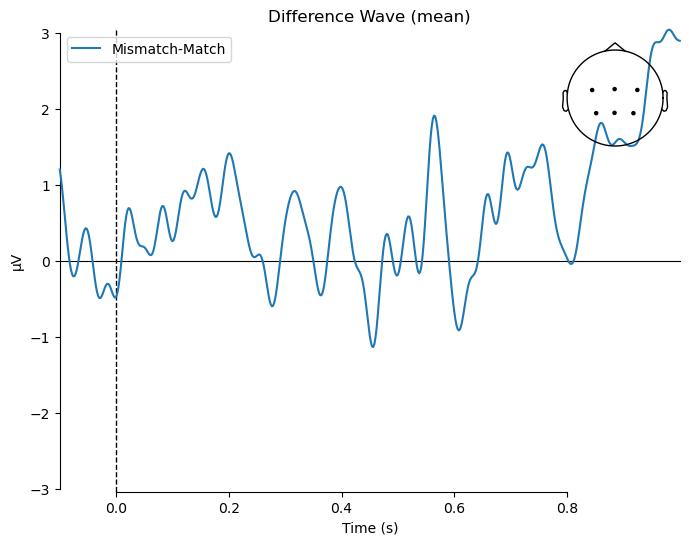

In [11]:
mne.viz.plot_compare_evokeds({'Mismatch-Match':evokeds_diff}, 
                             picks=roi, show_sensors='upper right',
                             combine='mean',
                             title='Difference Wave');


One advantage of difference waves is that they make it very clear when differences are occurring between conditions, and how large they are. When we compare waveforms for two conditions, the shape of the waveforms can sometimes make it hard to mentally compute the size of the difference - especially at time points when the waveforms' amplitudes are changing. In a difference waveform plot, the zero line clearly indicates no difference between conditions, and so the magnitude of the difference — as well as its timing — is easy to see. 

## Topoplot of Difference Waves

And we can plot the scalp distribution of the differences as well, which nicely shows the scalp distribution of the N400, starting around 576 ms and peaking around 700 ms — corresponding to the negative peak in the waveform plot above. This timing is quite late for the N400, which is typically observed from approximately 300–500 ms. However, in this study the participant was being trained on a new language, and so these ERPs reflect their brain's response to words that they had only recently learned. N400s are often delayed when people are processing a language they are less fluent in (e.g., [Newman et al., 2012](https://dx.doi.org/:10.1162/jocn_a_00143)).

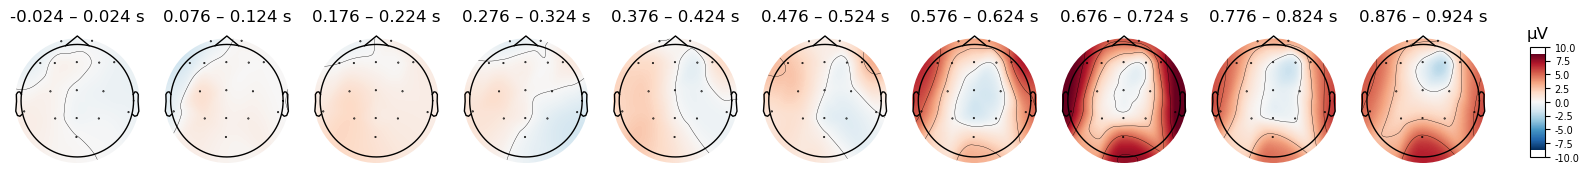

In [12]:
import numpy as np

# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, evokeds_diff.tmax, 0.1)

evokeds_diff.plot_topomap(times=times, average=0.050);

## Saving figures to files

Since MNE uses Matplotlib for its plotting duties, it is easy to save any MNE figure as an image file. The way to do this is somewhat non-intuitive. You have to run the plotting command with the `show=False` kwarg, and then running `plt.savefig()`. The figure will still show in your notebook (which is non-intuitive given the kwarg), but it will also be saved to the file name you specify. The extension you give the filename (e.g., `.png`, `.jpg`, `.pdf`) determines the image file format.

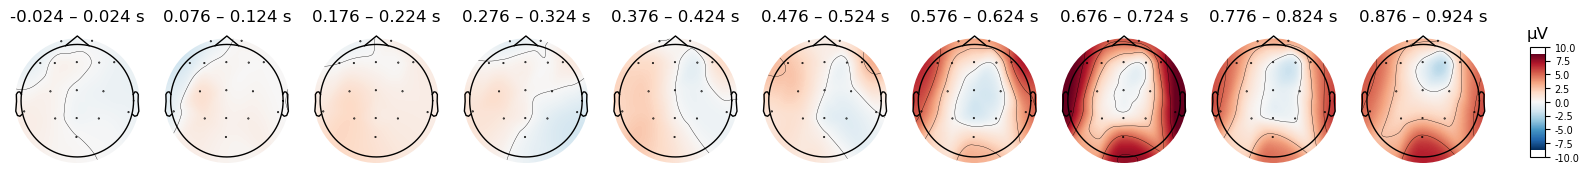

In [13]:
import matplotlib.pyplot as plt

evokeds_diff.plot_topomap(times=times, average=0.050, 
                          show=False)

plt.savefig('diffwave_topomaps.png')

## Summary

MNE provides useful tools for plotting ERP data, in particular for comparing waveforms between conditions — which is the main goal of most ERP experiments. The `mne.combine_evoked()` function can be used to create difference waveforms, which provide additional useful visualizations since they focus the viewer's attention on the differences between conditions, rather than the morphology of the individual condition waveforms.

After each individual participant's data has been preprocessed through a pipeline line this, the next step in analyzing an ERP experiment would be a group-level analysis. In a group-level analysis, the data from all participants would typically be averaged, and visualized using waveform plots and scalp topographic maps similar to the ones we've created here for one participant. 

Before we get to that, however, there is one more preprocessing step that we will examine: re-referencing. This is a step that is often performed after averaging, but before group-level analysis. We will examine this step in the next notebook.
